In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import time

# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Reshape, Conv1DTranspose, Conv2DTranspose

from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback


In [14]:
window = 6
P = 10
M = 6

In [15]:
# %% Load training data
file1 = 'Roaster_data_random150.csv'
file2 = 'Roaster_data_random151.csv'
file3 = 'Roaster_data_random152.csv'
file4 = 'Roaster_data_random153.csv'
file5 = 'Roaster_data_random154.csv'
file6 = 'Roaster_data_random155.csv'

train1 = pd.read_csv(file1, index_col=0)
train2 = pd.read_csv(file2, index_col=0)
train3 = pd.read_csv(file3, index_col=0)
train4 = pd.read_csv(file4, index_col=0)
train5 = pd.read_csv(file5, index_col=0)
train6 = pd.read_csv(file6, index_col=0)

train = pd.concat([train1, train2, train3, train4, train5], ignore_index=True)
# train = train1


In [16]:
train.O2[1:np.shape(train)[0]] = train.O2[0:np.shape(train)[0]-1]
train.CO2[1:np.shape(train)[0]] = train.CO2[0:np.shape(train)[0]-1]
train.SO2[1:np.shape(train)[0]] = train.SO2[0:np.shape(train)[0]-1]
train.TCM[1:np.shape(train)[0]] = train.TCM[0:np.shape(train)[0]-1]
train.FeS2[1:np.shape(train)[0]] = train.FeS2[0:np.shape(train)[0]-1]
train.CaCO3[1:np.shape(train)[0]] = train.CaCO3[0:np.shape(train)[0]-1]
train.T_1[1:np.shape(train)[0]] = train.T_1[0:np.shape(train)[0]-1]
train.T_2[1:np.shape(train)[0]] = train.T_2[0:np.shape(train)[0]-1]

In [17]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(y=train["Ore_amps"],name="Ore_amps"), row=1, col=1)
fig.add_trace(go.Scatter(y=train["Sulfur_tph"],name="Sulfur_tph"), row=1, col=1)
fig.add_trace(go.Scatter(y=train["O2_scfm"],name="O2_scfm"), row=1, col=1)
# fig.add_trace(go.Scatter(y=train["Carbon_in"],name="Carbon_in"), row=2, col=1)
# fig.add_trace(go.Scatter(y=train["Sulf_in"],name="Sulf_in"), row=2, col=1)
# fig.add_trace(go.Scatter(y=train["CO3_in"],name="CO3_in"), row=2, col=1)

fig.add_trace(go.Scatter(y=train["O2"],name="O2"), row=2, col=1)
fig.add_trace(go.Scatter(y=train["CO2"],name="CO2"), row=2, col=1)
fig.add_trace(go.Scatter(y=train["SO2"],name="SO2"), row=2, col=1)
fig.add_trace(go.Scatter(y=train["TCM"],name="TCM"), row=2, col=1)
fig.add_trace(go.Scatter(y=train["FeS2"],name="FeS2"), row=2, col=1)
fig.add_trace(go.Scatter(y=train["CaCO3"],name="CaCO3"), row=2, col=1)

fig.add_trace(go.Scatter(y=train["T_1"],name="T_1"), row=3, col=1)
fig.add_trace(go.Scatter(y=train["T_2"],name="T_2"), row=3, col=1)
              

In [18]:
Xm = train[['Ore_amps', 'Sulfur_tph', 'O2_scfm', 'Carbon_in','Sulf_in', 'CO3_in',\
                                'O2', 'CO2', 'SO2', 'TCM', 'FeS2', 'CaCO3', 'T_1', 'T_2']].to_numpy()
Ym = train[['O2', 'CO2', 'SO2', 'TCM', 'FeS2', 'CaCO3', 'T_1', 'T_2']].to_numpy()

nu = 6 # number of input (MV) variables
ny = 8 # number of output (CV) variables

In [19]:
# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
s2 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(Xm)
Ys = s2.fit_transform(Ym)

# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['Yscale'] = s2
model_params['window'] = window

# dump(model_params, open('model_param_Roaster.pkl', 'wb'))

In [20]:
# Snapshots for multistep model
X = []
Y = []
for i in range(window,len(Xs)-P):
    X.append(Xs[i-window:i+P,:])
    Y.append(Ys[i:i+P])


# Reshape data to format accepted by LSTM
X, Y = np.array(X), np.array(Y)

# Modifying "yhat" part of data for multistep model
for i in range(0, len(X)):
    for j in range(nu, nu+ny):
        X[i][window:,j] = X[i][window-1,j]

In [23]:
X.shape

(14984, 16, 14)

In [32]:
Xs[0:6+10,13]

array([0.09868518, 0.09868518, 0.12864773, 0.13656481, 0.13763255,
       0.13787959, 0.13795002, 0.13797521, 0.13798583, 0.13799063,
       0.13799277, 0.13799362, 0.14774664, 0.15843453, 0.16788801,
       0.17547504])

In [43]:
Ys[6:16,7]

array([0.13795002, 0.13797521, 0.13798583, 0.13799063, 0.13799277,
       0.13799362, 0.14774664, 0.15843453, 0.16788801, 0.17547504])

In [9]:
# create and train transformer model

# Initialize LSTM model
n_feature = X.shape[2]
n_label = Y.shape[1]

encoder_input = tf.keras.layers.Input(shape=(window+P, n_feature))
xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(encoder_input,encoder_input)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(xl,xl)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.Flatten()(xl)
xl = tf.keras.layers.Dense(units=Y.shape[1]*Y.shape[2], activation=None)(xl)
yl = tf.keras.layers.Reshape((Y.shape[1], Y.shape[2]))(xl)

model_trans = tf.keras.Model(inputs=encoder_input, outputs=yl, name="mhl")
model_trans.compile(optimizer='Adam',loss='MSE',metrics='accuracy')

# Allow for early exit
es_trans = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

Metal device set to: Apple M1 Pro


2022-07-12 18:12:12.405923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-12 18:12:12.406043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
t0 = time.time()
history = model_trans.fit(X,Y,epochs=300,batch_size=32, \
                               callbacks=[es_trans, TqdmCallback(verbose=1)], \
                               verbose=0)
t1 = time.time()

print('Runtime: %.2f s' %(t1-t0))

model_trans.summary()

# Plot loss
plt.figure(figsize=(8,4))
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')
plt.savefig('tclab_loss.png')
model_trans.save('model_trans15000-1.h5')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-07-12 18:12:12.604837: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-12 18:12:13.132871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 90: early stopping
Runtime: 1088.01 s
Model: "mhl"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 14)]     0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 16, 14)      1194        ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 16, 14)      0           ['multi_head_attention[0][0]',   
 da)                                                              'input_1[0][0]']                
                                                    

In [11]:
model_trans = load_model('model_trans15000.h5')

# Verify the fit of the model
Yp = model_trans.predict(X)

# Ypu = s2.inverse_transform(Yp)

Ypu = (Yp - s2.min_) * 1/s2.scale_ + s2.data_min_ 
Yu = (Y - s2.min_) * 1/s2.scale_ + s2.data_min_ 

2022-07-12 18:30:21.114046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


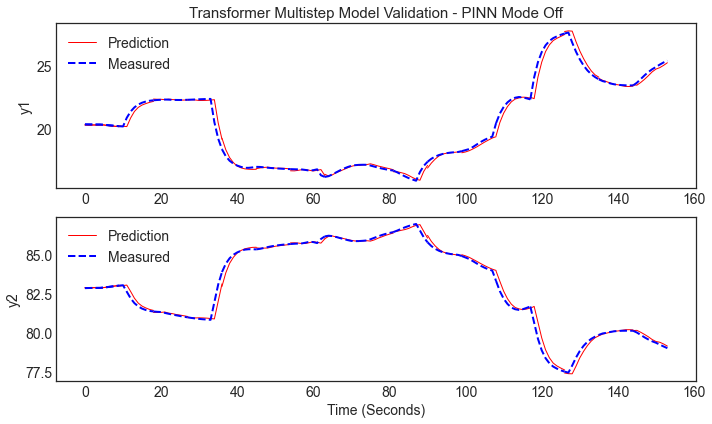

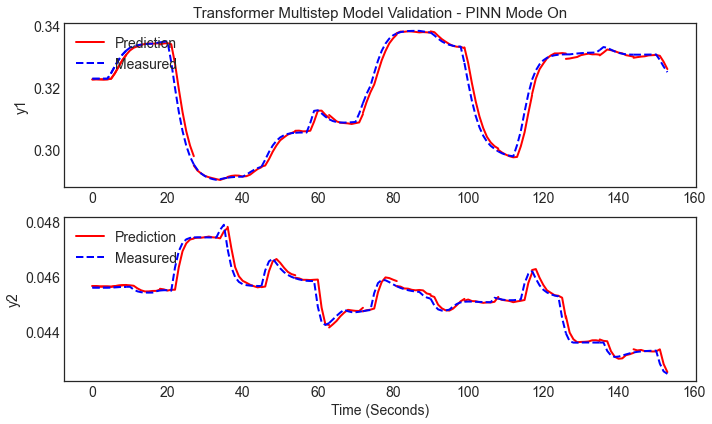

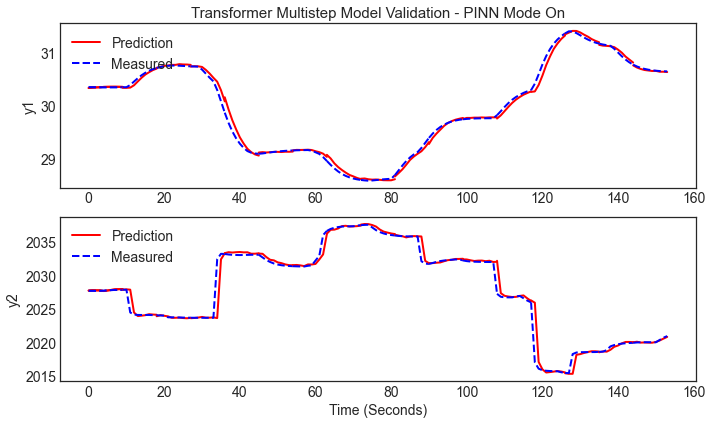

In [12]:
t=np.linspace(0,len(Yp)-1,len(Yp))



begin = 0
end = 150
skip = P-1


plt.style.use('seaborn-white')
plt.figure(0,figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t[begin:begin+P], Ypu[begin][:,0], '-', color="red",linewidth=1, label="Prediction")
plt.plot(t[begin:begin+P], Yu[begin][:,0], '--', color="blue",linewidth=2, label="Measured")
for i in range(begin,end,skip):   
    plt.plot(t[i:i+P], Ypu[i][:,0], '-',color="red",linewidth=1)
    plt.plot(t[i:i+P], Yu[i][:,0], '--', color="blue",linewidth=2)
    
plt.title('Transformer Multistep Model Validation - PINN Mode Off',fontsize=15)
plt.ylabel("y1", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tick_params(axis='both',labelsize=14)


plt.subplot(2,1,2)
plt.plot(t[begin:begin+P], Ypu[begin][:,1], '-',color="red",linewidth=1, label="Prediction")
plt.plot(t[begin:begin+P], Yu[begin][:,1], '--', color="blue",linewidth=2, label="Measured")
for i in range(begin,end,skip):   
    plt.plot(t[i:i+P], Ypu[i][:,1], '-',color="red",linewidth=1)
    plt.plot(t[i:i+P], Yu[i][:,1], '--', color="blue",linewidth=2)
    
plt.tight_layout()
plt.ylabel("y2", fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

# plt.savefig('TCLab_Training_Trans_multi_PINN_Off.eps', format='eps')
# plt.savefig('TCLab_Training_Trans_multi_PINN_Off.png', format='png')



plt.figure(1, figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t[begin:begin+P], Ypu[begin][:,3], '-',color="red",linewidth=2, label="Prediction")
plt.plot(t[begin:begin+P], Yu[begin][:,3], '--',color="blue", linewidth=2, label="Measured")

for i in range(begin,end,skip):   
    plt.plot(t[i:i+P], Ypu[i][:,3], '-',color="red",linewidth=2)
    plt.plot(t[i:i+P], Yu[i][:,3], '--', color="blue",linewidth=2)
    
plt.ylabel("y1", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.title('Transformer Multistep Model Validation - PINN Mode On',fontsize=15)    


plt.subplot(2,1,2)
plt.plot(t[begin:begin+P], Ypu[begin][:,4], '-',color="red",linewidth=2, label="Prediction")
plt.plot(t[begin:begin+P], Yu[begin][:,4], '--',color="blue", linewidth=2, label="Measured")

for i in range(begin,end,skip):   
    plt.plot(t[i:i+P], Ypu[i][:,4], '-',color="red",linewidth=2)
    plt.plot(t[i:i+P], Yu[i][:,4], '--',color="blue", linewidth=2)
    

plt.ylabel("y2", fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout() 


plt.figure(3, figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t[begin:begin+P], Ypu[begin][:,5], '-',color="red",linewidth=2, label="Prediction")
plt.plot(t[begin:begin+P], Yu[begin][:,5], '--',color="blue", linewidth=2, label="Measured")

for i in range(begin,end,skip):   
    plt.plot(t[i:i+P], Ypu[i][:,5], '-',color="red",linewidth=2)
    plt.plot(t[i:i+P], Yu[i][:,5], '--', color="blue",linewidth=2)
    
plt.ylabel("y1", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.title('Transformer Multistep Model Validation - PINN Mode On',fontsize=15)    


plt.subplot(2,1,2)
plt.plot(t[begin:begin+P], Ypu[begin][:,6], '-',color="red",linewidth=2, label="Prediction")
plt.plot(t[begin:begin+P], Yu[begin][:,6], '--',color="blue", linewidth=2, label="Measured")

for i in range(begin,end,skip):   
    plt.plot(t[i:i+P], Ypu[i][:,6], '-',color="red",linewidth=2)
    plt.plot(t[i:i+P], Yu[i][:,6], '--',color="blue", linewidth=2)
    

plt.ylabel("y2", fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout() 
    
# plt.savefig('TCLab_Training_Trans_multi_PINN_On.eps', format='eps')
# plt.savefig('TCLab_Training_Trans_multi_PINN_On.png', format='png')
    

plt.show()